In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import shutil
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [37]:
tumor_dir=r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

In [38]:
filepaths = []
label = []
dict_list = [tumor_dir, healthy_dir]

In [39]:
for i, j in enumerate(dict_list):
    f_list = os.listdir(j)
    for f in f_list:
        filepaths.append(os.path.join(j,f))
        if i == 0:
            label.append('tumor')
        else:
            label.append('healthy')
df = pd.DataFrame({'filepath':filepaths, 'label':label})
df.head()

,filepath,label
0,../input/brian-tumor-dataset/Brain Tumor Data ...,tumor
1,../input/brian-tumor-dataset/Brain Tumor Data ...,tumor
2,../input/brian-tumor-dataset/Brain Tumor Data ...,tumor
3,../input/brian-tumor-dataset/Brain Tumor Data ...,tumor
4,../input/brian-tumor-dataset/Brain Tumor Data ...,tumor


In [40]:
df['label'].value_counts(), df.shape

(label
 tumor      2513
 healthy    2087
 Name: count, dtype: int64,
 (4600, 2))

In [41]:
train, temp = train_test_split(df, test_size = 0.4, random_state = 42)
test, val = train_test_split(temp, test_size = 0.5, random_state = 42)
train.shape, test.shape, val.shape

((2760, 2), (920, 2), (920, 2))

In [43]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train_set = image_gen.flow_from_dataframe(dataframe= train,x_col="filepath",y_col="label",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test_set = image_gen.flow_from_dataframe(dataframe= test,x_col="filepath", y_col="label",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val_set = image_gen.flow_from_dataframe(dataframe= val,x_col="filepath", y_col="label",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2760 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [51]:
def show_brain_images(image_gen):
    test_dict = test_set.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

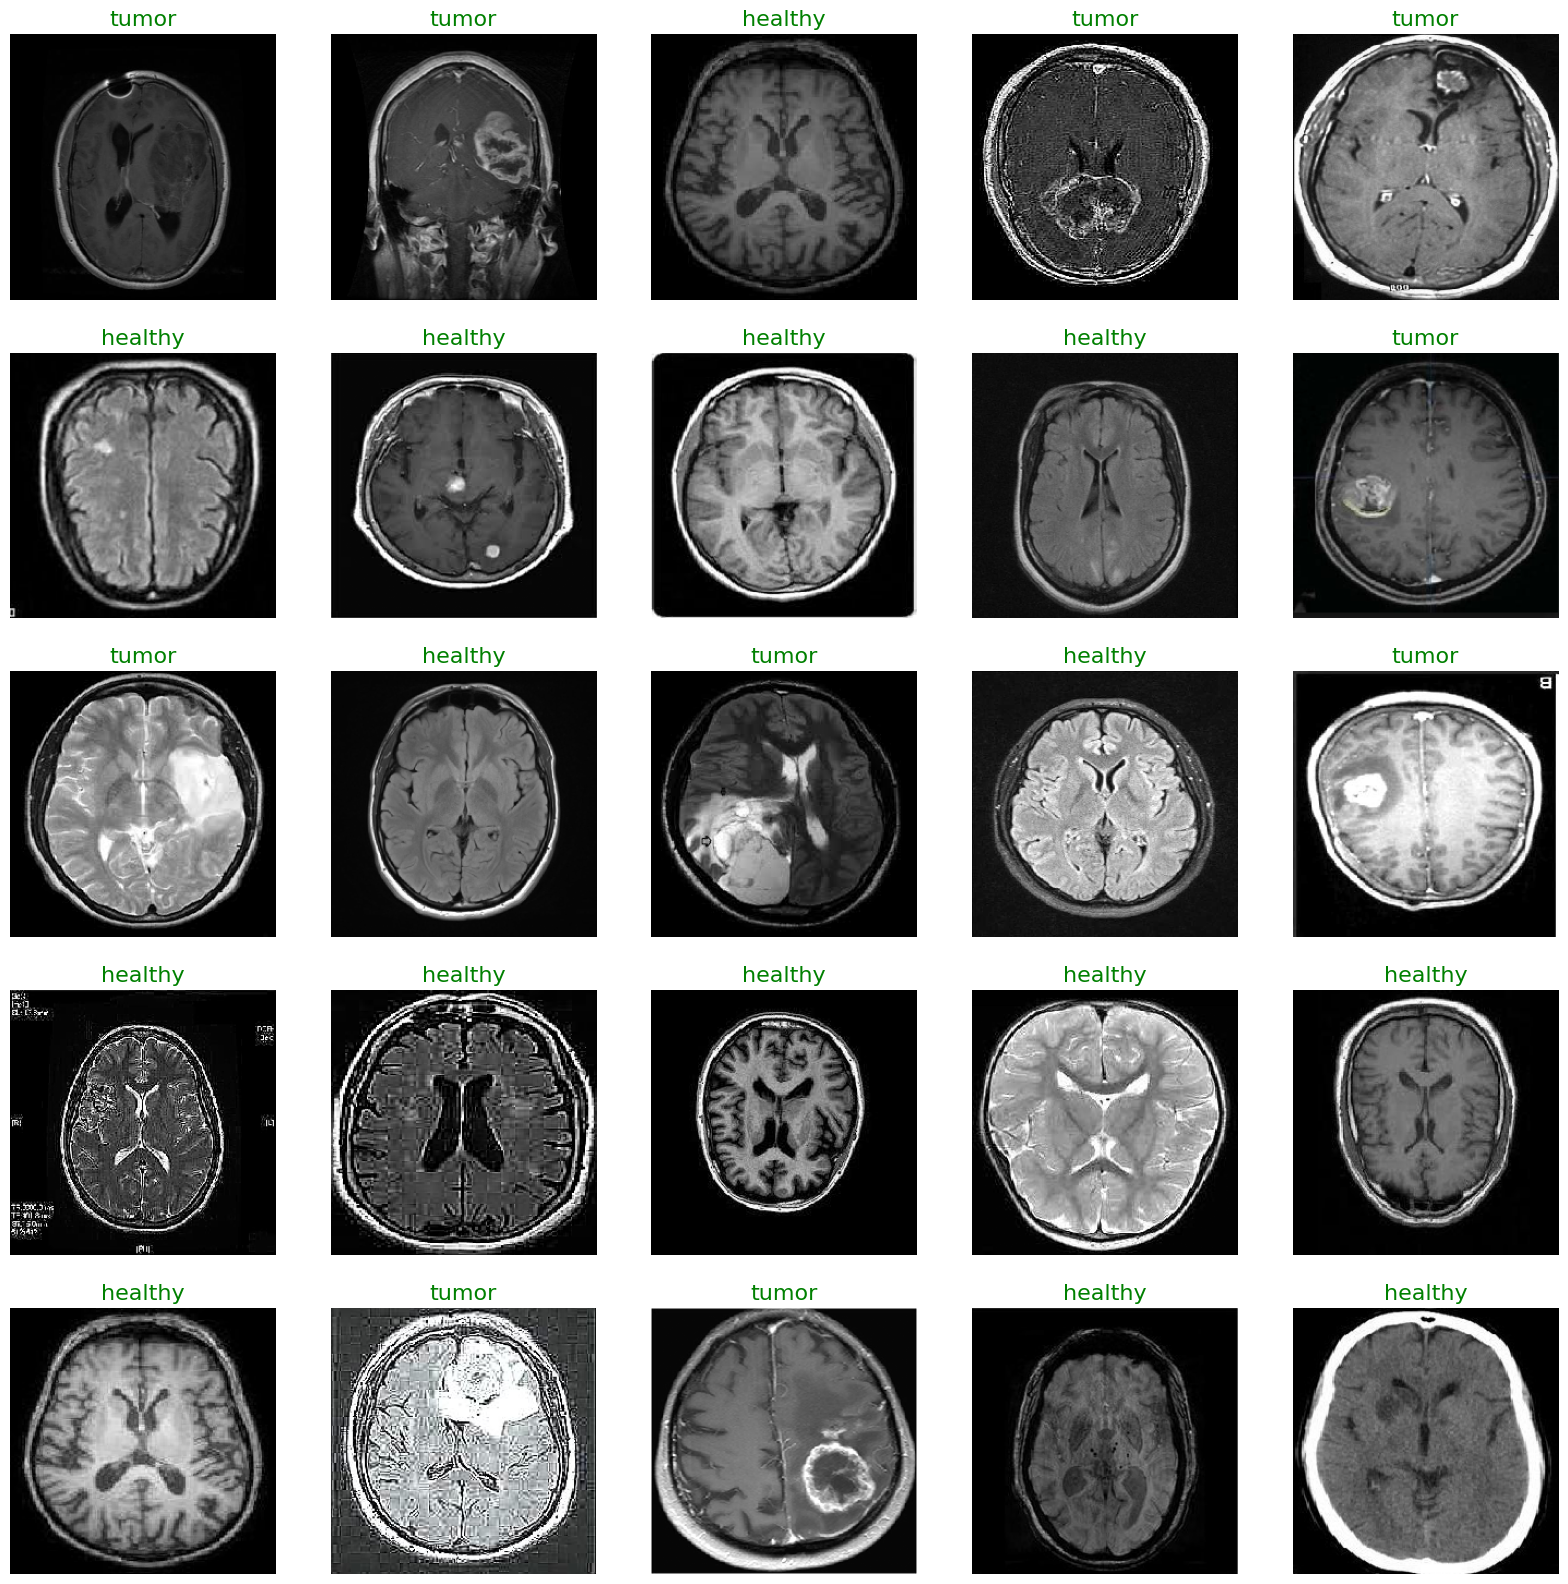

In [52]:
show_brain_images(train_set)

In [50]:
classes=list(train_set.class_indices.keys())
print (classes)

['healthy', 'tumor']


In [58]:
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(512, activation = "relu"))
model.add(Dense(2, activation="softmax")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [59]:
History = model.fit(train_set, validation_data= val_set, epochs=10,verbose=1)

Epoch 1/10
87/87 [==============================] - 221s 3s/step - loss: 0.6319 - accuracy: 0.6457 - val_loss: 0.5240 - val_accuracy: 0.7804
Epoch 2/10
87/87 [==============================] - 219s 3s/step - loss: 0.4133 - accuracy: 0.8239 - val_loss: 0.2878 - val_accuracy: 0.8826
Epoch 3/10
87/87 [==============================] - 223s 3s/step - loss: 0.2354 - accuracy: 0.9054 - val_loss: 0.1699 - val_accuracy: 0.9348
Epoch 4/10
87/87 [==============================] - 227s 3s/step - loss: 0.1168 - accuracy: 0.9609 - val_loss: 0.1184 - val_accuracy: 0.9652
Epoch 5/10
87/87 [==============================] - 224s 3s/step - loss: 0.0666 - accuracy: 0.9775 - val_loss: 0.1250 - val_accuracy: 0.9522
Epoch 6/10
87/87 [==============================] - 225s 3s/step - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.1277 - val_accuracy: 0.9587
Epoch 7/10
87/87 [==============================] - 227s 3s/step - loss: 0.0336 - accuracy: 0.9891 - val_loss: 0.1312 - val_accuracy: 0.9717
Epoch 8/10
87

In [ ]:
evaluation = model.evaluate(val_set)

# Print the evaluation results (e.g., loss and accuracy for classification)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])